# ***Who Grade Binary Classification***

This notebook shows the process of classifying samples into binary who grade (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from skimage.morphology import disk
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser
from pathlib import Path

# Define default font size
plt.rcParams.update({'font.size': 12})

### ***Consistency***
Next, let's make sure notebook is not random:

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [3]:
# Define folder that contains the dhg dataset
DHG_PATH = "./../DHG/"
# Define folder that contains the preprocessed dataset
PREPROCESSED_PATH = f"{DHG_PATH}/preprocessed"
# Define file that contains dhg metadata
METADATA_PATH = f"{DHG_PATH}/metadata.csv"
# Define folder to save classification models for later use
MODELS_PATH = f"./../models/binary_who_grade_classification"
# Define path to save plots
PLOTS_PATH = "./../plots_and_their_data/binary_who_grade_classification"
# Define mass resolution of the data
MASS_RESOLUTION = 0.025
# Define spectra dimension
SPECTRA_DIM = 92000
# Define number of epochs
EPOCHS = 100
# Define batch size
BATCH_SIZE = 256
# Define learning rate
LEARNING_RATE = 1e-3
# Define representative peaks 
REPRESENTATIVE_PEAKS = [794.5, 834.5, 886.6]

### ***Creating output folder***

Next, let's create the output folder:

In [4]:
# Create output folder if doesn't exist
Path(PLOTS_PATH).mkdir(parents=True, exist_ok=True)
Path(MODELS_PATH).mkdir(parents=True, exist_ok=True)

### ***Define function to read a MSI***

Next, let's define a function to read a MSI:

In [5]:
def read_msi(p: ImzMLParser) -> Tuple[np.ndarray, np.ndarray]:
  """
    Function to read a continuos imzML parser object into a numpy array.

    Args:
        p (ImzMLParser): The imzML parser.
    Returns:
        Tuple[np.ndarray, np.ndarray]: Numpy 3D matrix where y coordinate
            (axis=0), x coordinate (axis=1), intensities values (axis=2)
            and continuos mzs values.

  """
  # Get shape of mzs values
  max_z = p.mzLengths[0]
  # Get shape of y axis
  max_y = p.imzmldict["max count of pixels y"]
  # Get shape of x axis
  max_x = p.imzmldict["max count of pixels x"]
  # Create empty numpy 3D matrix
  msi = np.zeros((max_y, max_x, max_z))
  # Loop over each coordinate and add to 3D matrix
  for i, (x, y, _) in enumerate(p.coordinates):
    # Get mzs and intensities
    mzs, ints = p.getspectrum(i)
    # Add intensities to x,y coordinate
    msi[y - 1, x - 1, :] = ints
  return mzs, msi

### ***Reading MSI metadata file***

Next, let's read the metadata file:

In [6]:
# Read clinical state annotations csv
metadata_df = pd.read_csv(METADATA_PATH)
# Separate section and replica
s_metadata_df = metadata_df[metadata_df.sample_type == "section"]
r_metadata_df = metadata_df[metadata_df.sample_type == "replica"]

### ***Get single spectra information from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all images:

In [7]:
# Create dict's to store each sample spectra's mean and std
# for non-tissue spectra's
sample_non_tissue_mean = {}
sample_non_tissue_std = {}

# Create lists to store each spectra's info
spectras_info = []

# Loop over each MSI
for index, row in tqdm(
    metadata_df.iterrows(), total=metadata_df.shape[0], desc="MSI Loop"
):
  # Parse the MSI file
  with ImzMLParser(
      os.path.join(PREPROCESSED_PATH, f"{row.sample_file_name}.imzML")
  ) as reader:
    # Get full msi
    mzs, data = read_msi(reader)

    # Define filter of representative peaks
    filter_all = False
    for peak in REPRESENTATIVE_PEAKS:
      filter_all |= (mzs >=
                     peak - MASS_RESOLUTION) & (mzs <= peak + MASS_RESOLUTION)
    
    # Get representative peaks accumulative image
    representative_peaks_img = data[:, :, filter_all].sum(axis=-1)
    
    # Remove salt and pepper noise
    smooth = filters.median(representative_peaks_img, disk(2))
    
    # Threshold image
    thresh_img = (smooth > filters.threshold_mean(smooth))

    # Get non-tissue spectra's mean
    sample_non_tissue_mean[row.sample_file_name
                          ] = data[~thresh_img, :].mean(axis=0)
    
    # Get non-tissue spectra's std
    sample_non_tissue_std[row.sample_file_name
                         ] = data[~thresh_img, :].std(axis=0)

    # Loop over each spectra
    spectra_info = []
    for idx, (x, y, z) in tqdm(
        enumerate(reader.coordinates), total=len(reader.coordinates),
        desc="Spectra Loop"
    ):
      # Append spectra info
      spectras_info.append(
          [
              row.sample_file_name, row.sample_type, row.sample_number,
              row.histology, row.who_grade, x, y, idx,
              (True if thresh_img[y - 1, x - 1] else False)
          ]
      )

# Convert to data frame
spectras_info = pd.DataFrame(
    spectras_info, columns=[
        "file_name", "sample_type", "sample_number", "histology", "who_grade",
        "x_coordinate", "y_coordinate", "idx", "is_tissue"
    ]
)
spectras_info["label"] = (spectras_info["who_grade"] > 2).astype(int)

# Separate section and replica
s_spectras_info = spectras_info[spectras_info.sample_type == "section"]
r_spectras_info = spectras_info[spectras_info.sample_type == "replica"]

MSI Loop: 100%|██████████| 50/50 [04:35<00:00,  5.51s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [8]:
# Opening parsers
parsers = {
    file_name:
    ImzMLParser(os.path.join(PREPROCESSED_PATH, f"{file_name}.imzML"))
    for file_name in metadata_df.sample_file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [9]:
def map_record(file_name: tf.Tensor, idx: tf.Tensor,
               label: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map a record to model input (spectra) and output (label).

  Args:
      file_name (tf.Tensor): Record file name to get spectra.
      idx (tf.Tensor): Record index to get spectra.
      label (tf.Tensor): Record label.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding from the EagerTensor object
  file_name, idx, label = (file_name.numpy(), idx.numpy(), label.numpy())

  # Decode bytes to str
  file_name = file_name.decode('utf-8')

  # Reading spectra from parser
  _, spectra = parsers[file_name].getspectrum(idx)

  # Apply zscore
  spectra = (
      (spectra - sample_non_tissue_mean[file_name]) /
      sample_non_tissue_std[file_name]
  )

  # Return spectra and label
  return (spectra, label)

def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(
    file_names: np.ndarray, indexes: np.ndarray, labels: np.ndarray,
    batch_size: int, shuffle: bool
) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      file_names (np.ndarray): file names of the dataset.
      indexes (np.ndarray): indexes of the dataset.
      labels (np.ndarray): labels of the dataset.
      batch_size (int): batch size.
      shuffle (bool): flag to indicate if to shuffle or not.

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset
  ds = tf.data.Dataset.from_tensor_slices((file_names, indexes, labels))
  # Shuffle the data
  if shuffle:
    ds = ds.shuffle(len(data), seed=SEED)
  # Map record to model input
  ds = ds.map(
      lambda i, j, k: tf.py_function(
          func=map_record, inp=[i, j, k], Tout=[tf.float32, tf.int32]
      )
  )
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batch's to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [10]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.LeakyReLU(alpha=0.2),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1024),
      layers.LeakyReLU(alpha=0.2),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(512),
      layers.LeakyReLU(alpha=0.2),
      layers.BatchNormalization(),
      layers.Dropout(0.3),
      layers.Dense(1, activation='sigmoid')
    ]
  )
  """
  return tf.keras.Sequential(
      [
          layers.InputLayer(input_shape=(SPECTRA_DIM,)),
          layers.Dropout(0.2),
          layers.Dense(
              1024, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.5),
          layers.Dense(
              512, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.5),
          layers.Dense(
              512, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.5),
          layers.Dense(
              38, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.5),
          layers.Dense(
              32, kernel_regularizer=regularizers.l1(0.001),
              bias_regularizer=regularizers.l1(0.001)
          ),
          layers.BatchNormalization(),
          layers.LeakyReLU(alpha=0.2),
          layers.Dropout(0.2),
          layers.Dense(1, activation='sigmoid')
      ]
  """
  

In [11]:
"""
def get_model() -> tf.keras.Model:
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,1)),
      layers.Reshape((SPECTRA_DIM,1)),
      layers.Conv1D(filters=64, kernel_size=11),
      layers.LeakyReLU(alpha=0.2),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ]
  )
"""

"\ndef get_model() -> tf.keras.Model:\n  return tf.keras.Sequential(\n    [\n      layers.InputLayer(input_shape=(SPECTRA_DIM,1)),\n      layers.Reshape((SPECTRA_DIM,1)),\n      layers.Conv1D(filters=64, kernel_size=11),\n      layers.LeakyReLU(alpha=0.2),\n      layers.MaxPooling1D(pool_size=2),\n      layers.Flatten(),\n      layers.Dense(32, activation='relu'),\n      layers.Dense(1, activation='sigmoid')\n    ]\n  )\n"

In [12]:
get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 92000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              94209024  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0

In [13]:
"""
def get_model() -> tf.keras.Model:
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.GaussianNoise(0.01),
      #layers.Dropout(0.66),
      layers.Dense(1024),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(1024),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(512),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(256),
      layers.BatchNormalization(),
      layers.LeakyReLU(alpha=0.2),
      #layers.Dropout(0.66),
      layers.Dense(1, activation='sigmoid')
    ]
  )

def get_model() -> tf.keras.Model:
  return tf.keras.Sequential(
    [
      layers.Input(shape=(SPECTRA_DIM,1)),
      layers.Conv1D(filters=64, kernel_size=11, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(32, activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ]
  )
  """

"\ndef get_model() -> tf.keras.Model:\n  return tf.keras.Sequential(\n    [\n      layers.InputLayer(input_shape=(SPECTRA_DIM,)),\n      layers.GaussianNoise(0.01),\n      #layers.Dropout(0.66),\n      layers.Dense(1024),\n      layers.BatchNormalization(),\n      layers.LeakyReLU(alpha=0.2),\n      #layers.Dropout(0.66),\n      layers.Dense(1024),\n      layers.BatchNormalization(),\n      layers.LeakyReLU(alpha=0.2),\n      #layers.Dropout(0.66),\n      layers.Dense(512),\n      layers.BatchNormalization(),\n      layers.LeakyReLU(alpha=0.2),\n      #layers.Dropout(0.66),\n      layers.Dense(256),\n      layers.BatchNormalization(),\n      layers.LeakyReLU(alpha=0.2),\n      #layers.Dropout(0.66),\n      layers.Dense(1, activation='sigmoid')\n    ]\n  )\n\ndef get_model() -> tf.keras.Model:\n  return tf.keras.Sequential(\n    [\n      layers.Input(shape=(SPECTRA_DIM,1)),\n      layers.Conv1D(filters=64, kernel_size=11, activation='relu'),\n      layers.MaxPooling1D(pool_size=2),\n   

### ***Section classification:***
Next, let's apply classification on section samples.

#### ***Training:***
Next, let"s create a classification model for each leave one sample out option:

In [14]:
# Define dict's to store validation and training metrics
train_metrics = {}
validation_metrics = {}

# Loop over each image
for exclude_image, group in tqdm(s_metadata_df.groupby("file_name")):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get all spectra's in the exclude_image to exclude them
  exclude_spectras = s_spectras_info["sample_number"].isin(
      group.sample_number.to_list()
  )

  # Create filter for training data - does not include the excluded image
  # and only include tissue spectra's
  train_filter = ((~exclude_spectras) & s_spectras_info.is_tissue)

  # Get x and y data for training
  X = s_spectras_info.loc[train_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[train_filter, "label"]

  # Split to train and validation set
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=SEED, stratify=y
  )

  # Create data generators
  train_generator = create_ds(
      X_train.iloc[:, 0].to_numpy(), X_train.iloc[:, 1].to_numpy(),
      y_train.to_numpy(), BATCH_SIZE, True
  )
  validation_generator = create_ds(
      X_val.iloc[:, 0].to_numpy(), X_val.iloc[:, 1].to_numpy(),
      y_val.to_numpy(), BATCH_SIZE, True
  )

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(
      MODELS_PATH, f"section_excluded_{exclude_image}/"
  )
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath, save_weights_only=False,
      monitor="val_loss", mode="min", save_best_only=True
  )

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=10
  )

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(),
      metrics=["binary_accuracy"]
  )

  # Train the classification model
  history = classification_model.fit(
      x=train_generator, validation_data=validation_generator, epochs=EPOCHS,
      callbacks=[model_checkpoint_callback, model_es_callback]
  )

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evaluate on train and validation
  train_metrics[exclude_image] = classification_model.evaluate(
      x=train_generator
  )
  validation_metrics[exclude_image] = classification_model.evaluate(
      x=validation_generator
  )

  # Clean model for next iteration
  classification_model = None

  # Separate training
  print("#" * 30)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/100
96/96 [==============================] - 40s 397ms/step - loss: 0.1216 - binary_accuracy: 0.9557 - val_loss: 0.0323 - val_binary_accuracy: 0.9901
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 1-s\assets
Epoch 2/100
96/96 [==============================] - 31s 322ms/step - loss: 0.0125 - binary_accuracy: 0.9956 - val_loss: 0.0525 - val_binary_accuracy: 0.9855
Epoch 3/100
96/96 [==============================] - 33s 342ms/step - loss: 0.0070 - binary_accuracy: 0.9975 - val_loss: 0.0589 - val_binary_accuracy: 0.9834
Epoch 4/100
96/96 [==============================] - 31s 326ms/step - loss: 0.0045 - binary_accuracy: 0.9984 - val_loss: 0.0665 - val_binary_accuracy: 0.9824
Epoch 5/100
96/96 [==============================] - 32s 338ms/step - loss: 0.0053 - binary_accuracy: 0.9982 - val_loss: 0.0423 - val_binary_accuracy: 0.9855
Epoch 6/100
96/96 [==============================] - 33s 341ms/step - loss: 0.0040 - binary_accuracy

 11%|█         | 1/9 [07:15<58:04, 435.55s/it]

##############################
Epoch 1/100
83/83 [==============================] - 32s 373ms/step - loss: 0.1224 - binary_accuracy: 0.9540 - val_loss: 0.0399 - val_binary_accuracy: 0.9869
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 11-11-12-s\assets
Epoch 2/100
83/83 [==============================] - 31s 377ms/step - loss: 0.0134 - binary_accuracy: 0.9953 - val_loss: 0.0407 - val_binary_accuracy: 0.9865
Epoch 3/100
83/83 [==============================] - 30s 361ms/step - loss: 0.0096 - binary_accuracy: 0.9972 - val_loss: 0.0508 - val_binary_accuracy: 0.9844
Epoch 4/100
83/83 [==============================] - 31s 371ms/step - loss: 0.0061 - binary_accuracy: 0.9980 - val_loss: 0.0546 - val_binary_accuracy: 0.9825
Epoch 5/100
83/83 [==============================] - 32s 379ms/step - loss: 0.0053 - binary_accuracy: 0.9980 - val_loss: 0.0498 - val_binary_accuracy: 0.9833
Epoch 6/100
83/83 [==============================] - 28s 337ms

 22%|██▏       | 2/9 [20:29<1:15:23, 646.21s/it]

##############################
Epoch 1/100
92/92 [==============================] - 37s 392ms/step - loss: 0.1207 - binary_accuracy: 0.9574 - val_loss: 0.0347 - val_binary_accuracy: 0.9879
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 14-13-s\assets
Epoch 2/100
92/92 [==============================] - 35s 386ms/step - loss: 0.0160 - binary_accuracy: 0.9946 - val_loss: 0.0541 - val_binary_accuracy: 0.9838
Epoch 3/100
92/92 [==============================] - 36s 386ms/step - loss: 0.0099 - binary_accuracy: 0.9966 - val_loss: 0.1054 - val_binary_accuracy: 0.9768
Epoch 4/100
92/92 [==============================] - 34s 372ms/step - loss: 0.0060 - binary_accuracy: 0.9978 - val_loss: 0.1030 - val_binary_accuracy: 0.9778
Epoch 5/100
92/92 [==============================] - 35s 380ms/step - loss: 0.0057 - binary_accuracy: 0.9980 - val_loss: 0.0834 - val_binary_accuracy: 0.9810
Epoch 6/100
92/92 [==============================] - 36s 386ms/st

 33%|███▎      | 3/9 [27:58<55:38, 556.38s/it]  

##############################
Epoch 1/100
94/94 [==============================] - 39s 401ms/step - loss: 0.0959 - binary_accuracy: 0.9648 - val_loss: 0.0427 - val_binary_accuracy: 0.9881
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 16-15-s\assets
Epoch 2/100
94/94 [==============================] - 38s 400ms/step - loss: 0.0083 - binary_accuracy: 0.9973 - val_loss: 0.0261 - val_binary_accuracy: 0.9920
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 16-15-s\assets
Epoch 3/100
94/94 [==============================] - 35s 375ms/step - loss: 0.0043 - binary_accuracy: 0.9986 - val_loss: 0.0651 - val_binary_accuracy: 0.9853
Epoch 4/100
94/94 [==============================] - 37s 394ms/step - loss: 0.0036 - binary_accuracy: 0.9986 - val_loss: 0.0654 - val_binary_accuracy: 0.9841
Epoch 5/100
94/94 [==============================] - 37s 388ms/step - loss: 0.0032 - binary_accuracy: 0.9990 

 44%|████▍     | 4/9 [36:25<44:44, 536.86s/it]

##############################
Epoch 1/100
96/96 [==============================] - 40s 404ms/step - loss: 0.1032 - binary_accuracy: 0.9631 - val_loss: 0.0435 - val_binary_accuracy: 0.9875
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 19-18-s\assets
Epoch 2/100
96/96 [==============================] - 37s 390ms/step - loss: 0.0092 - binary_accuracy: 0.9972 - val_loss: 0.0483 - val_binary_accuracy: 0.9877
Epoch 3/100
96/96 [==============================] - 37s 385ms/step - loss: 0.0056 - binary_accuracy: 0.9983 - val_loss: 0.0799 - val_binary_accuracy: 0.9818
Epoch 4/100
96/96 [==============================] - 37s 387ms/step - loss: 0.0045 - binary_accuracy: 0.9983 - val_loss: 0.0818 - val_binary_accuracy: 0.9833
Epoch 5/100
96/96 [==============================] - 37s 380ms/step - loss: 0.0098 - binary_accuracy: 0.9966 - val_loss: 0.0871 - val_binary_accuracy: 0.9788
Epoch 6/100
96/96 [==============================] - 36s 372ms/st

 56%|█████▌    | 5/9 [44:10<34:04, 511.02s/it]

##############################
Epoch 1/100
77/77 [==============================] - 31s 397ms/step - loss: 0.0955 - binary_accuracy: 0.9647 - val_loss: 0.0118 - val_binary_accuracy: 0.9967
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 29-25-23-21-20-s\assets
Epoch 2/100
77/77 [==============================] - 29s 381ms/step - loss: 0.0081 - binary_accuracy: 0.9976 - val_loss: 0.0286 - val_binary_accuracy: 0.9945
Epoch 3/100
77/77 [==============================] - 30s 392ms/step - loss: 0.0036 - binary_accuracy: 0.9987 - val_loss: 0.0276 - val_binary_accuracy: 0.9936
Epoch 4/100
77/77 [==============================] - 31s 397ms/step - loss: 0.0021 - binary_accuracy: 0.9993 - val_loss: 0.0246 - val_binary_accuracy: 0.9932
Epoch 5/100
77/77 [==============================] - 30s 388ms/step - loss: 0.0015 - binary_accuracy: 0.9996 - val_loss: 0.0371 - val_binary_accuracy: 0.9920
Epoch 6/100
77/77 [==============================] - 29s

 67%|██████▋   | 6/9 [50:30<23:18, 466.21s/it]

##############################
Epoch 1/100
97/97 [==============================] - 41s 409ms/step - loss: 0.1056 - binary_accuracy: 0.9610 - val_loss: 0.0199 - val_binary_accuracy: 0.9931
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 6-7-s\assets
Epoch 2/100
97/97 [==============================] - 40s 414ms/step - loss: 0.0129 - binary_accuracy: 0.9950 - val_loss: 0.0582 - val_binary_accuracy: 0.9840
Epoch 3/100
97/97 [==============================] - 40s 411ms/step - loss: 0.0072 - binary_accuracy: 0.9975 - val_loss: 0.0503 - val_binary_accuracy: 0.9840
Epoch 4/100
97/97 [==============================] - 38s 388ms/step - loss: 0.0046 - binary_accuracy: 0.9984 - val_loss: 0.0432 - val_binary_accuracy: 0.9860
Epoch 5/100
97/97 [==============================] - 39s 400ms/step - loss: 0.0048 - binary_accuracy: 0.9986 - val_loss: 0.0663 - val_binary_accuracy: 0.9811
Epoch 6/100
97/97 [==============================] - 40s 414ms/step

 78%|███████▊  | 7/9 [58:37<15:45, 473.00s/it]

##############################
Epoch 1/100
73/73 [==============================] - 31s 411ms/step - loss: 0.1133 - binary_accuracy: 0.9579 - val_loss: 0.0386 - val_binary_accuracy: 0.9877
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 8-12-5-4-3-2-s\assets
Epoch 2/100
73/73 [==============================] - 31s 419ms/step - loss: 0.0096 - binary_accuracy: 0.9965 - val_loss: 0.0289 - val_binary_accuracy: 0.9903
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 8-12-5-4-3-2-s\assets
Epoch 3/100
73/73 [==============================] - 29s 397ms/step - loss: 0.0060 - binary_accuracy: 0.9983 - val_loss: 0.0226 - val_binary_accuracy: 0.9920
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 8-12-5-4-3-2-s\assets
Epoch 4/100
73/73 [==============================] - 30s 409ms/step - loss: 0.0103 - binary_accuracy: 0.9964 - val_loss: 0.0532 - va

 89%|████████▉ | 8/9 [1:12:52<09:54, 594.79s/it]

##############################
Epoch 1/100
96/96 [==============================] - 42s 424ms/step - loss: 0.1031 - binary_accuracy: 0.9615 - val_loss: 0.0287 - val_binary_accuracy: 0.9914
INFO:tensorflow:Assets written to: ./../models/binary_who_grade_classification\section_excluded_HG 9-10-s\assets
Epoch 2/100
96/96 [==============================] - 37s 387ms/step - loss: 0.0103 - binary_accuracy: 0.9963 - val_loss: 0.0526 - val_binary_accuracy: 0.9863
Epoch 3/100
96/96 [==============================] - 36s 372ms/step - loss: 0.0063 - binary_accuracy: 0.9978 - val_loss: 0.0426 - val_binary_accuracy: 0.9875
Epoch 4/100
96/96 [==============================] - 36s 374ms/step - loss: 0.0048 - binary_accuracy: 0.9985 - val_loss: 0.0411 - val_binary_accuracy: 0.9880
Epoch 5/100
96/96 [==============================] - 36s 375ms/step - loss: 0.0048 - binary_accuracy: 0.9981 - val_loss: 0.0507 - val_binary_accuracy: 0.9858
Epoch 6/100
96/96 [==============================] - 37s 389ms/ste

100%|██████████| 9/9 [1:20:37<00:00, 537.45s/it]

##############################


In [15]:
# Create data frame of train metrics
train_metrics_df = pd.DataFrame.from_dict(
    train_metrics, orient='index', columns=["loss", "binary_accuracy"]
)
# Save data frame
train_metrics_df.to_csv(f"{PLOTS_PATH}/section_train_metrics.csv")
# Print
train_metrics_df

,loss,binary_accuracy
HG 1-s,0.001219,0.999552
HG 11-11-12-s,0.000025,1.000000
HG 14-13-s,0.002045,0.999487
HG 16-15-s,0.000181,0.999958
HG 19-18-s,0.004173,0.998604
HG 29-25-23-21-20-s,0.005514,0.999129
HG 6-7-s,0.001929,0.999354
HG 8-12-5-4-3-2-s,0.000008,1.000000
HG 9-10-s,0.001520,0.999512


In [16]:
# Create data frame of validation metrics
validation_metrics_df = pd.DataFrame.from_dict(
    validation_metrics, orient='index', columns=["loss", "binary_accuracy"]
)
# Save data frame
validation_metrics_df.to_csv(f"{PLOTS_PATH}/section_validation_metrics.csv")
# Print
validation_metrics_df

,loss,binary_accuracy
HG 1-s,0.032312,0.990059
HG 11-11-12-s,0.026251,0.990507
HG 14-13-s,0.034670,0.987872
HG 16-15-s,0.026077,0.991976
HG 19-18-s,0.043533,0.987521
HG 29-25-23-21-20-s,0.011751,0.996719
HG 6-7-s,0.019877,0.993059
HG 8-12-5-4-3-2-s,0.015999,0.995692
HG 9-10-s,0.028745,0.991374


#### ***Evaluation on section tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [17]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [02:00<00:00,  4.83s/it]


Next, let's get some statistics about each left out section sample predictions:

In [18]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{PLOTS_PATH}/section_section_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 11_1-s,0.0011774853,1.0000000000,0.9999583960,0.9721922278,0.1203727350,1,1
HG 11_2-s,0.0051811994,1.0000000000,0.9992340803,0.9103240371,0.2277711779,1,1
HG 12-s,0.0000824291,1.0000000000,0.9999918342,0.9313740730,0.2038646191,1,1
HG 14-s,0.0047239861,1.0000000000,0.9999744892,0.9835298061,0.0977362767,1,1
HG 13-s,0.0000372321,0.9999988079,0.9930643439,0.9199330807,0.1947410256,1,1
HG 15-s,0.0000000000,0.9999994040,0.0000012156,0.1719965041,0.3428857625,1,0
HG 16-s,0.2913903892,1.0000000000,1.0000000000,0.9975855350,0.0292275753,0,1
HG 19-s,0.0000000000,0.9999959469,0.0011599513,0.2866779864,0.4203516543,0,0
HG 18-s,0.0000000000,0.9999995232,0.0000001265,0.1117489338,0.3047411144,0,0


Next, let's evaluate the classification performance image-wise:

In [19]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_section_tissue_image_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.640
Balanced  Accuracy: 0.622
Precision: 0.733
Recall: 0.688
F1 score: 0.710



Next, let's plot the roc curve image-wise:

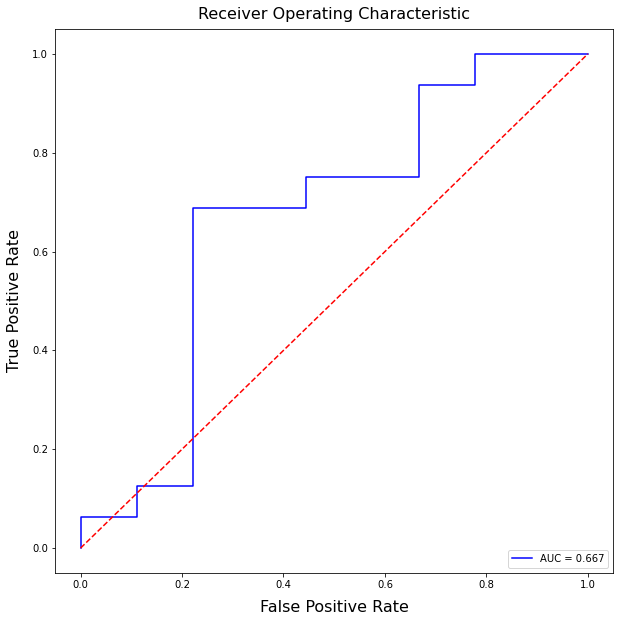

In [20]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

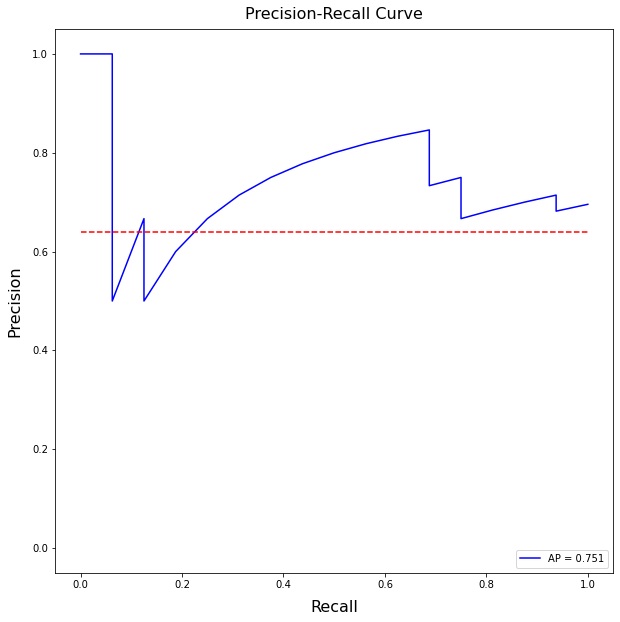

In [21]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [22]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_section_tissue_spectra_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.676
Balanced  Accuracy: 0.658
Precision: 0.734
Recall: 0.738
F1 score: 0.736



Next, let's plot the roc curve spectra-wise:

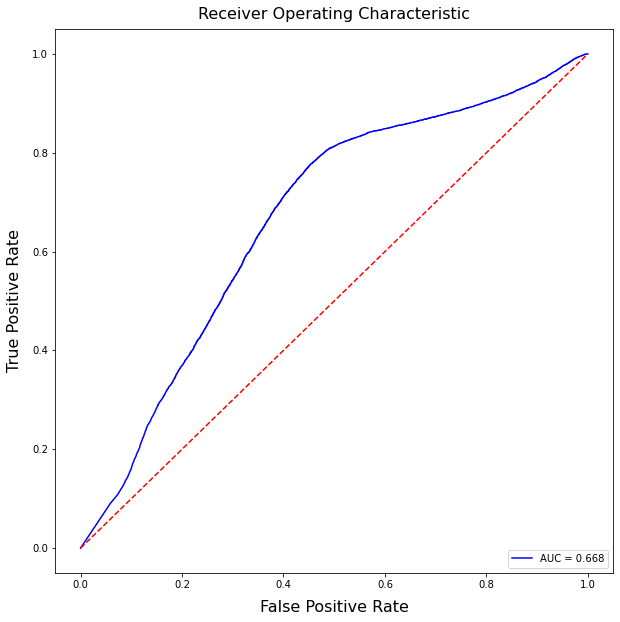

In [23]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

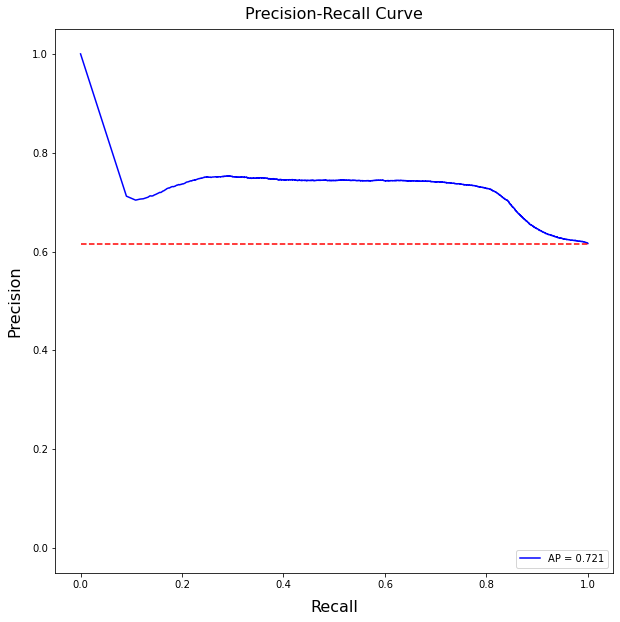

In [24]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

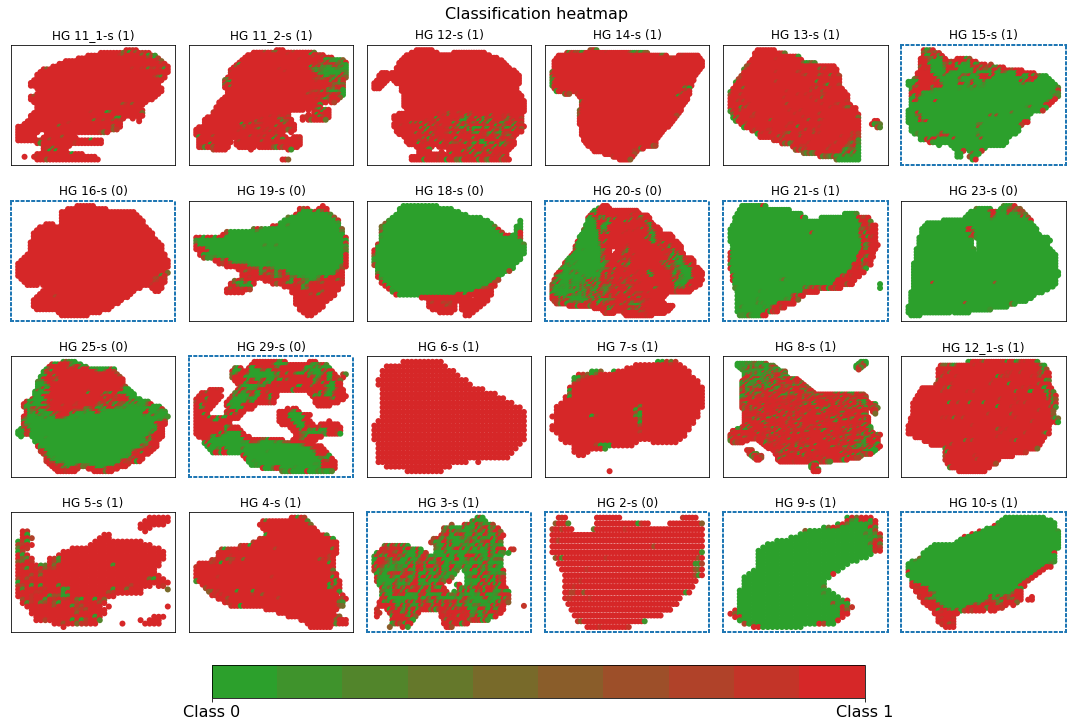

In [25]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

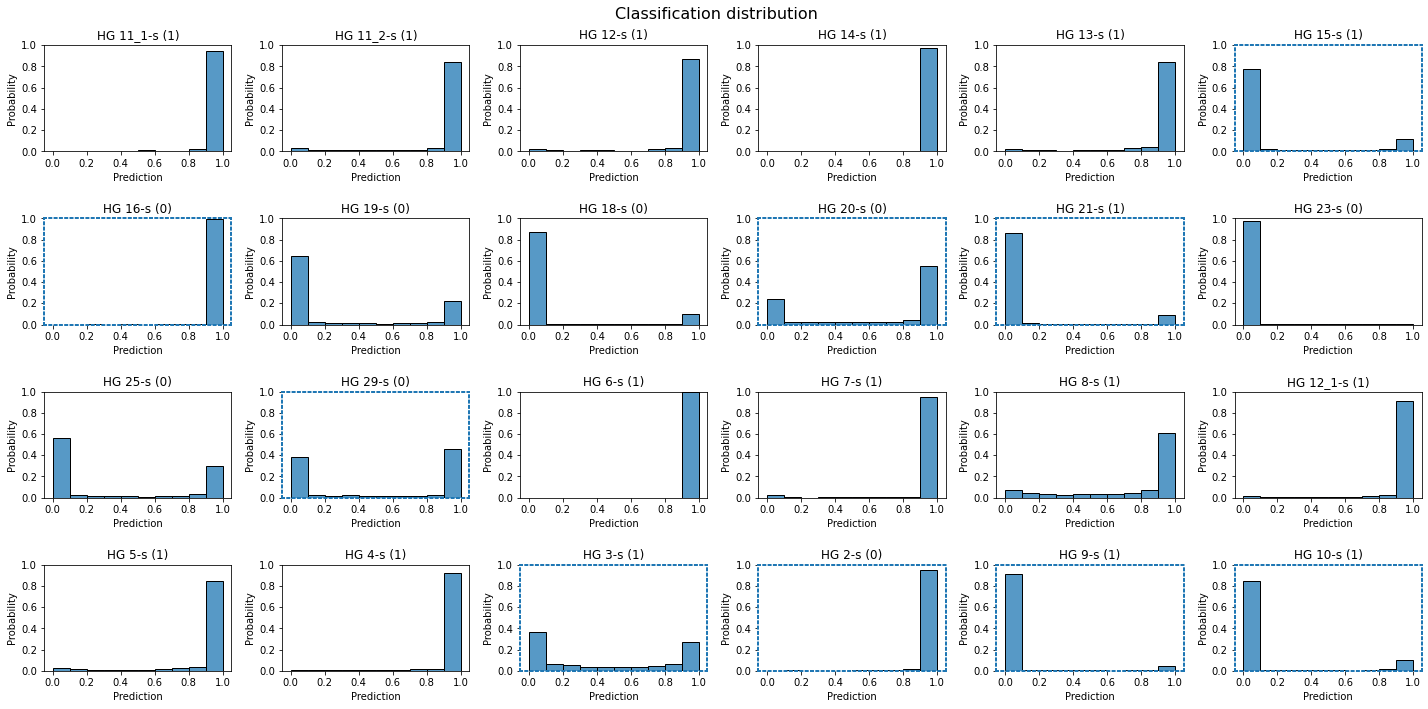

In [26]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_section_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [27]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            s_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            s_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{PLOTS_PATH}/section_section_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on section non-tissue spectra's:***

Next, let's get the prediction of each of left out section sample spectra's:

In [28]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    s_metadata_df.iterrows(), total=s_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for test data
  test_filter = (
      (s_spectras_info["file_name"] == row.sample_file_name) &
      ~s_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = s_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = s_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{row.file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [03:21<00:00,  8.07s/it]


Next, let's get some statistics about each left out section sample predictions:

In [29]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{PLOTS_PATH}/section_section_non_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 11_1-s,0.0002404674,1.0000000000,0.9992906451,0.9395728707,0.1788423955,1,1
HG 11_2-s,0.0000131233,1.0000000000,0.9993734360,0.9327660203,0.1920700818,1,1
HG 12-s,0.0000653015,1.0000000000,0.9993463159,0.9333580136,0.1926189661,1,1
HG 14-s,0.0000147664,1.0000000000,0.9999556541,0.9583765268,0.1667073071,1,1
HG 13-s,0.0011104784,1.0000000000,0.9999645352,0.9628511071,0.1500671804,1,1
HG 15-s,0.0000000000,1.0000000000,0.9997957349,0.9471971989,0.1875721216,1,1
HG 16-s,0.0070908903,1.0000000000,0.9996711016,0.9785443544,0.0895859897,0,1
HG 19-s,0.0000000000,1.0000000000,0.9999972582,0.9690443277,0.1657464653,0,1
HG 18-s,0.0001279474,1.0000000000,0.9999976158,0.9926667213,0.0763937756,0,1


Next, let's evaluate the classification performance image-wise:

In [30]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_section_non_tissue_image_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.640
Balanced  Accuracy: 0.500
Precision: 0.640
Recall: 1.000
F1 score: 0.780



Next, let's plot the roc curve image-wise:

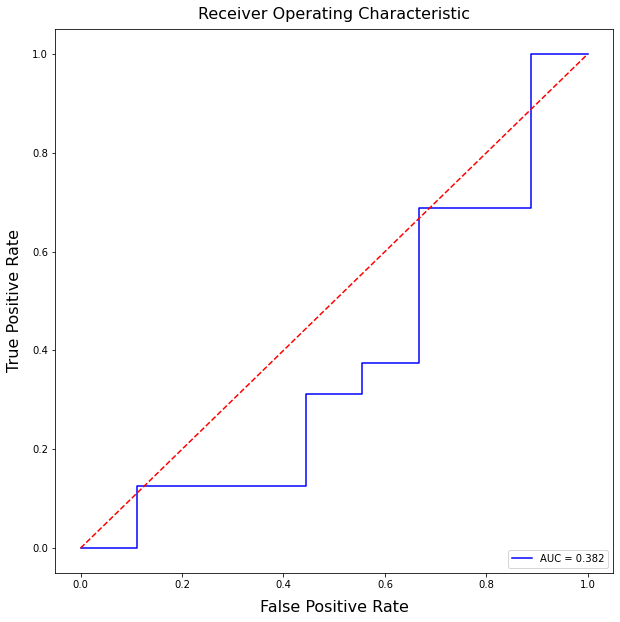

In [31]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

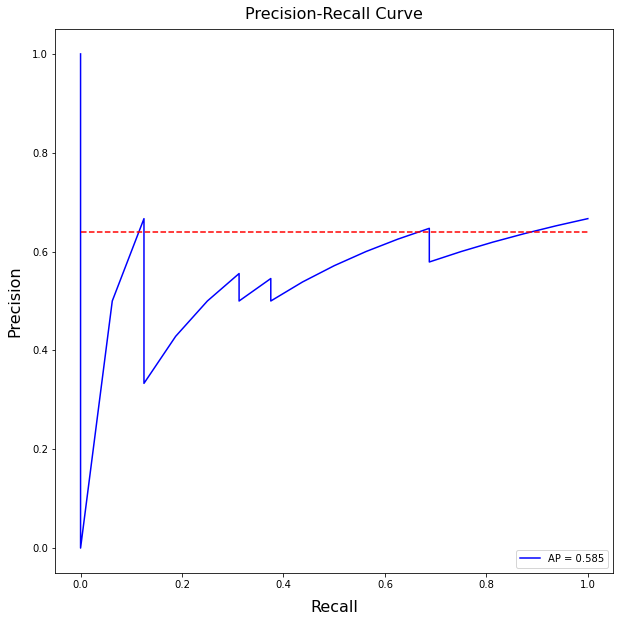

In [32]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [33]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_section_non_tissue_spectra_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.549
Balanced  Accuracy: 0.414
Precision: 0.832
Recall: 0.599
F1 score: 0.697



Next, let's plot the roc curve spectra-wise:

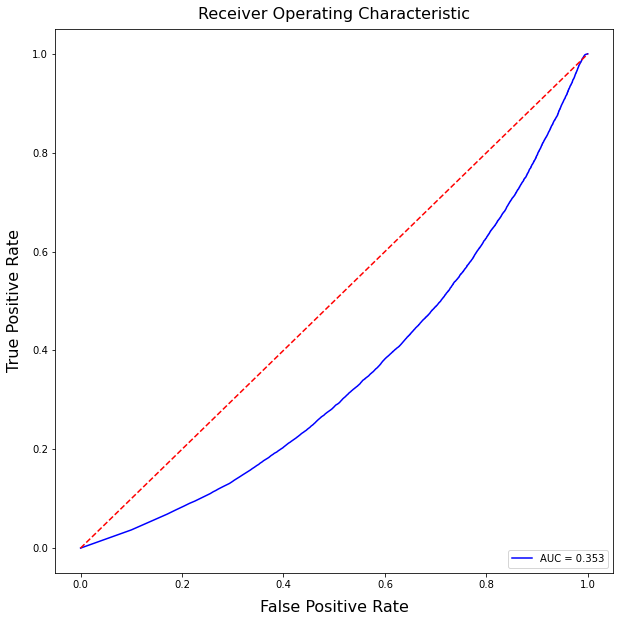

In [34]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

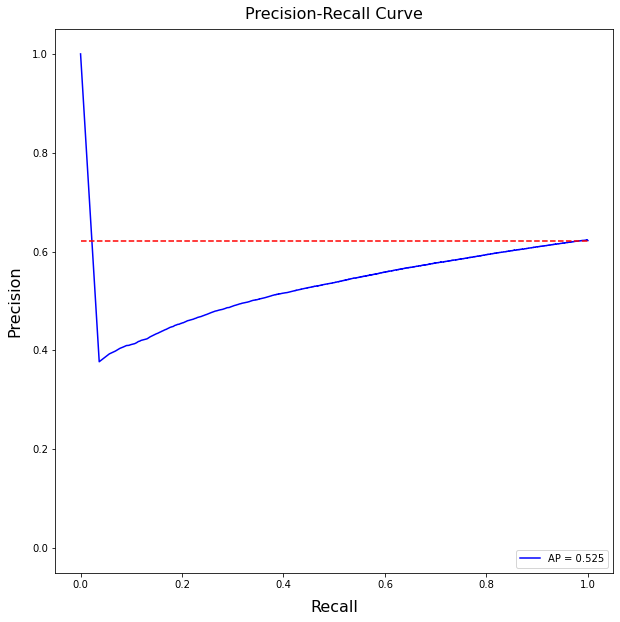

In [35]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

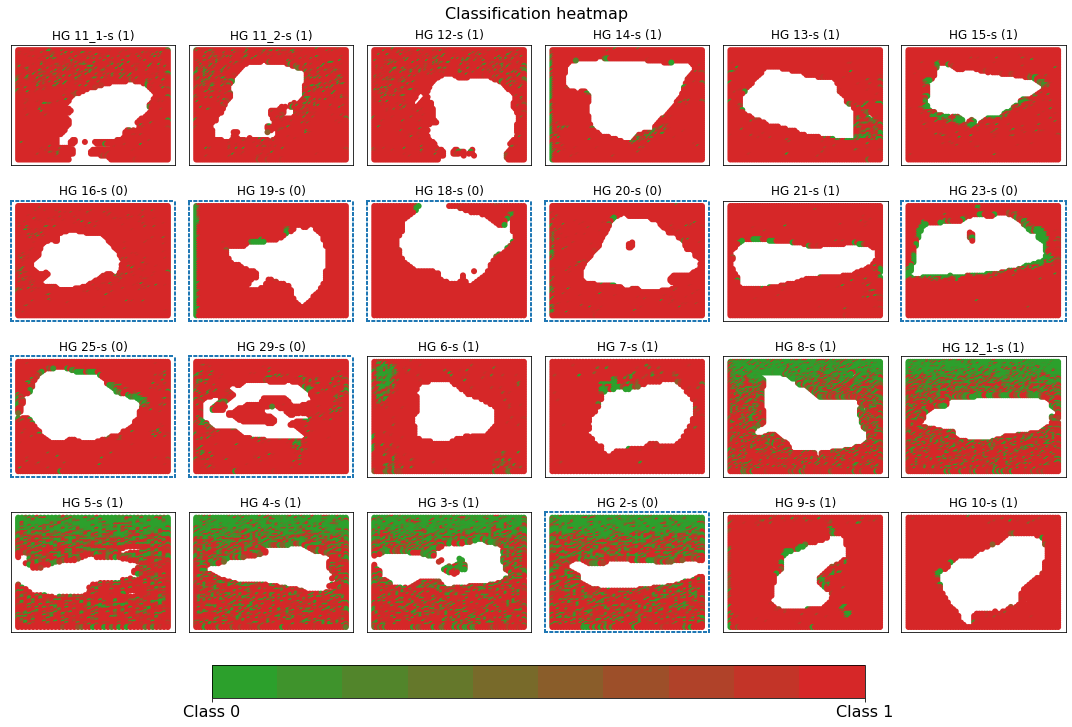

In [36]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].x_coordinate - 1,
      s_spectras_info[(s_spectras_info.file_name == key) &
                      ~s_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

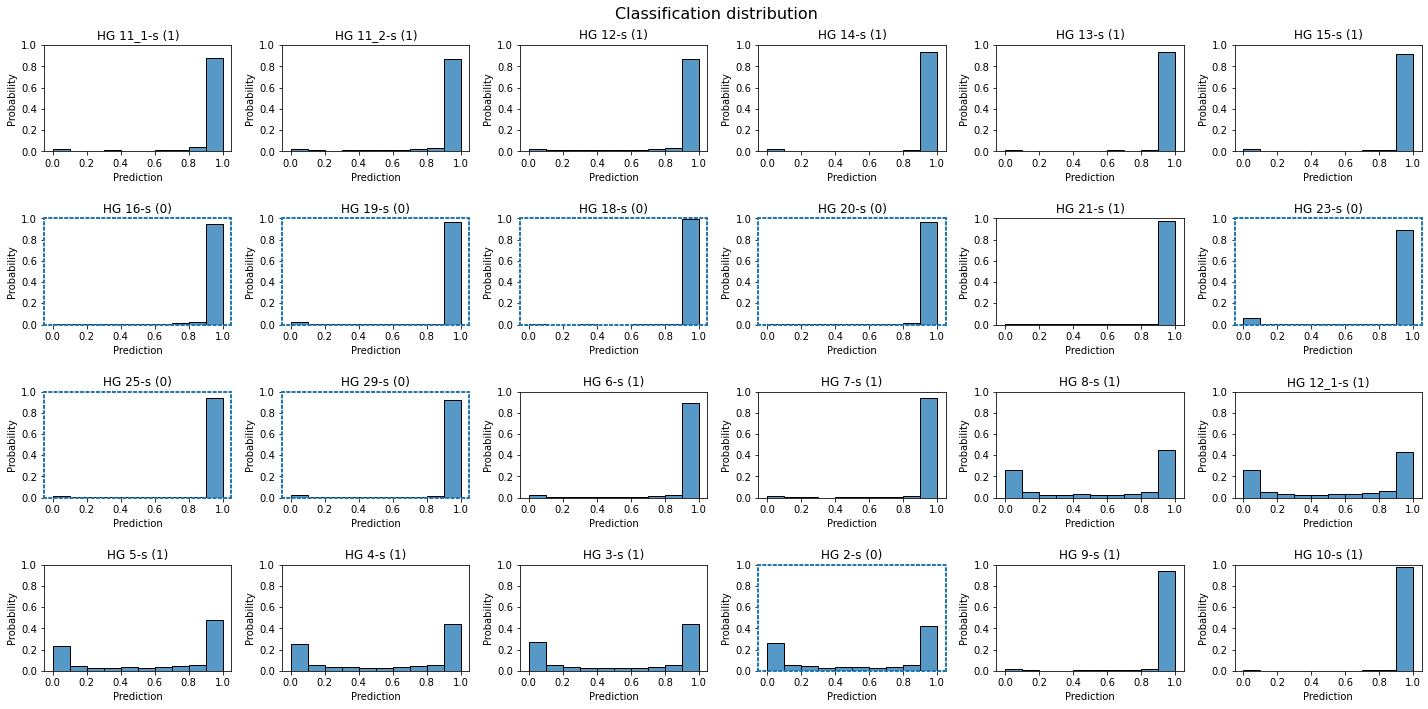

In [37]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_section_non_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [38]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            ~s_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        s_spectras_info[
                            (s_spectras_info.file_name == key) &
                            ~s_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{PLOTS_PATH}/section_section_non_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on replica tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [39]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get the section sample_file_name
  s_file_name = s_metadata_df[s_metadata_df.sample_number == row.sample_number
                             ].iloc[0].file_name

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{s_file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [02:43<00:00,  6.55s/it]


Next, let's get some statistics about each left out section sample predictions:

In [40]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{PLOTS_PATH}/section_replica_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 12-r,0.9543478489,1.0000000000,0.9999699593,0.9998294711,0.0012709345,1,1
HG 11-r,0.0023283227,1.0000000000,0.9999032617,0.9560267925,0.1497489959,1,1
HG 14-r,0.0008243682,0.9999996424,0.9964376688,0.8613979220,0.2788717151,1,1
HG 13-r,0.0020301116,0.9999980927,0.9970009923,0.9539154768,0.1666897684,1,1
HG 16-r,0.4129259884,0.9999992847,0.9998102784,0.9971753359,0.0259740744,0,1
HG 15-r,0.0000013153,0.9999997616,0.9891573787,0.9382891655,0.1429609358,1,1
HG 18_1-r,0.0010752692,1.0000000000,0.9854668379,0.9237947464,0.1614465415,0,1
HG 19-r,0.0051314449,1.0000000000,0.9943990707,0.9682089686,0.0864595249,0,1
HG 18_2-r,0.1046709269,1.0000000000,0.9329267740,0.9031394124,0.1067724898,0,1


Next, let's evaluate the classification performance image-wise:

In [41]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_replica_tissue_image_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.680
Balanced  Accuracy: 0.600
Precision: 0.652
Recall: 1.000
F1 score: 0.789



Next, let's plot the roc curve image-wise:

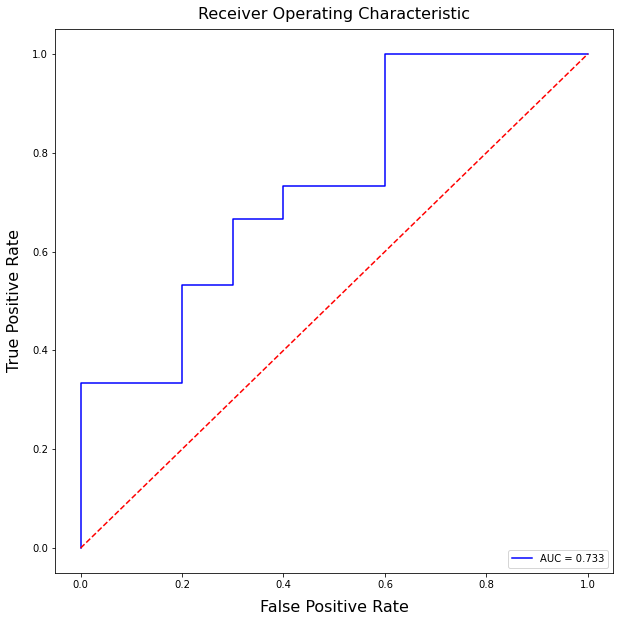

In [42]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

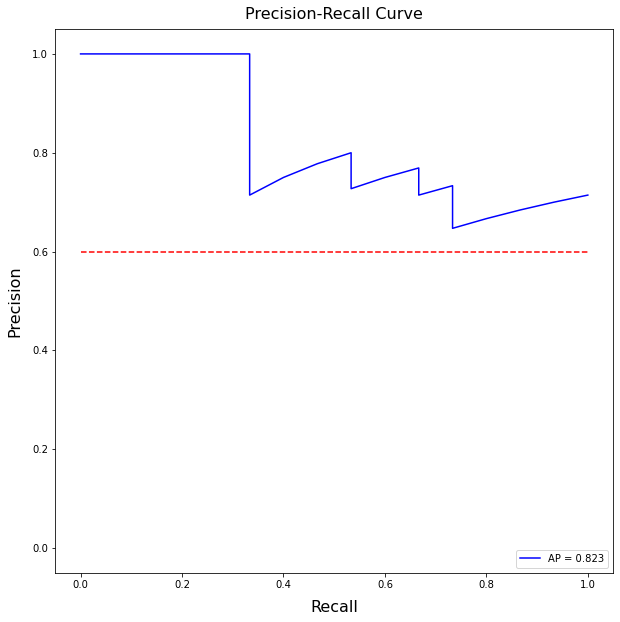

In [43]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [44]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_replica_tissue_spectra_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.608
Balanced  Accuracy: 0.646
Precision: 0.909
Recall: 0.590
F1 score: 0.715



Next, let's plot the roc curve spectra-wise:

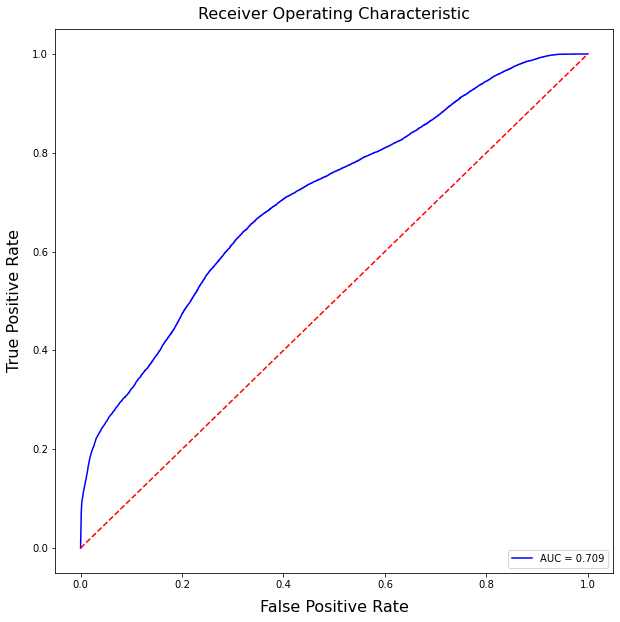

In [45]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

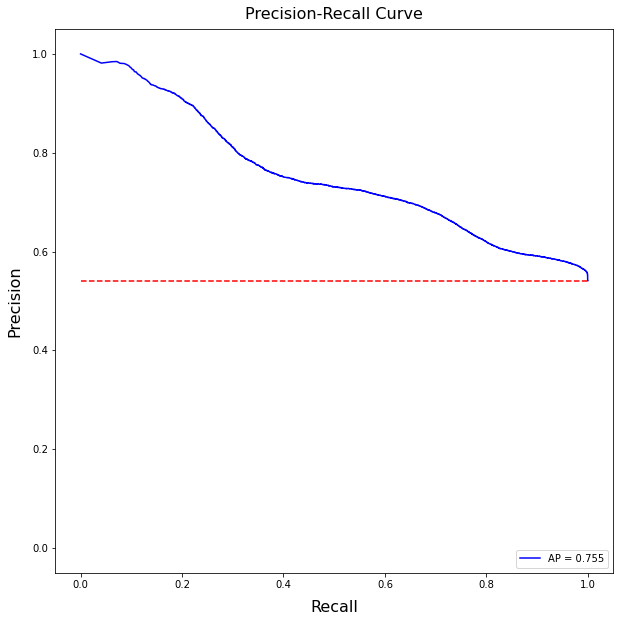

In [46]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

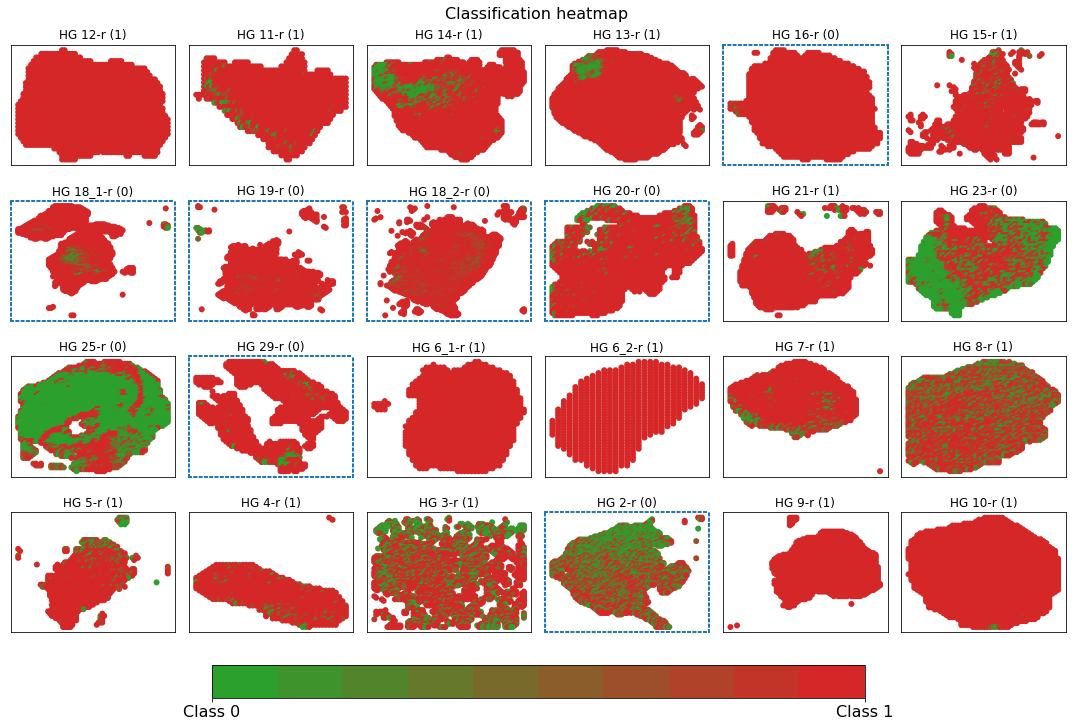

In [47]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

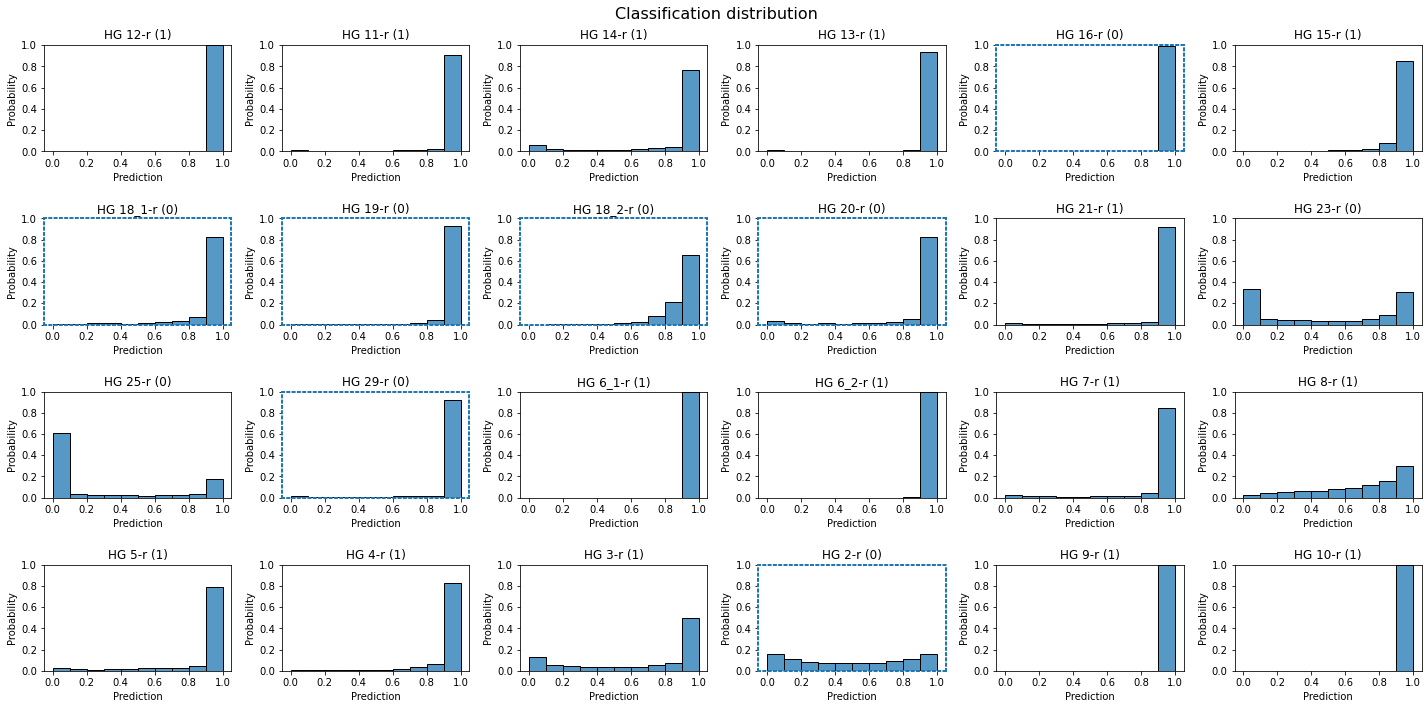

In [48]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [49]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            r_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            r_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{PLOTS_PATH}/section_section_tissue_spectra_wise_predictions.csv",
    index=False
)

#### ***Evaluation on replica non-tissue spectra's:***

Next, let's get the prediction of each of left out replica sample spectra's:

In [50]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for index, row in tqdm(
    r_metadata_df.iterrows(), total=r_metadata_df.shape[0], desc="MSI Loop"
):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Get the section sample_file_name
  s_file_name = s_metadata_df[s_metadata_df.sample_number == row.sample_number
                             ].iloc[0].file_name

  # Create filter for test data
  test_filter = (
      (r_spectras_info["file_name"] == row.sample_file_name) &
      ~r_spectras_info["is_tissue"]
  )

  # Get x and y data for training
  X = r_spectras_info.loc[test_filter, ["file_name", "idx"]]
  y = r_spectras_info.loc[test_filter, "label"]

  # Create test data generator
  test_generator = create_ds(
      X.iloc[:, 0].to_numpy(), X.iloc[:, 1].to_numpy(), y.to_numpy(),
      BATCH_SIZE, False
  )

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"section_excluded_{s_file_name}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[row.sample_file_name
             ] = classification_model.predict(x=test_generator)

  # Get corresponding true labels
  true_labels[row.sample_file_name] = y.to_numpy()

  # Clean model for next iteration
  classification_model = None

MSI Loop: 100%|██████████| 25/25 [04:11<00:00, 10.04s/it]


Next, let's get some statistics about each left out section sample predictions:

In [51]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create data frmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min()
)
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max()
)
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key])
)
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean()
)
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std()
)
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0]
)
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Set index
model_eval.set_index("sample_left_out", inplace=True)
# Save data frame
model_eval.to_csv(f"{PLOTS_PATH}/section_replica_non_tissue_pred_stats.csv")
# Print statistics
model_eval

,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
sample_left_out,,,,,,,
HG 12-r,0.0000000000,1.0000000000,0.9990262389,0.9022063017,0.2563189566,1,1
HG 11-r,0.0000048646,1.0000000000,0.9987120032,0.9146206975,0.2218356729,1,1
HG 14-r,0.0000000000,1.0000000000,0.9998906851,0.9338418245,0.2296935022,1,1
HG 13-r,0.0000000024,1.0000000000,0.9998783469,0.9499352574,0.1967789382,1,1
HG 16-r,0.0000000023,1.0000000000,0.9996197224,0.9247778654,0.2473170906,0,1
HG 15-r,0.0000000000,1.0000000000,0.9991961718,0.9474921823,0.1985857934,1,1
HG 18_1-r,0.0000000000,1.0000000000,0.9994046688,0.9660710692,0.1383500695,0,1
HG 19-r,0.0000000042,1.0000000000,0.9998169541,0.9664187431,0.1588831842,0,1
HG 18_2-r,0.0000000000,1.0000000000,0.9998387098,0.9699768424,0.1376987249,0,1


Next, let's evaluate the classification performance image-wise:

In [52]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Save performance
file_name = "section_replica_non_tissue_image_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.600
Balanced  Accuracy: 0.500
Precision: 0.600
Recall: 1.000
F1 score: 0.750



Next, let's plot the roc curve image-wise:

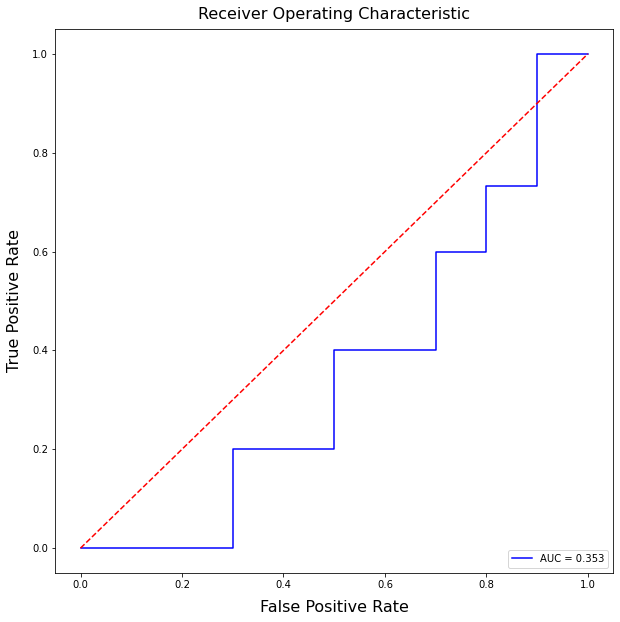

In [53]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_image_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve image-wise:

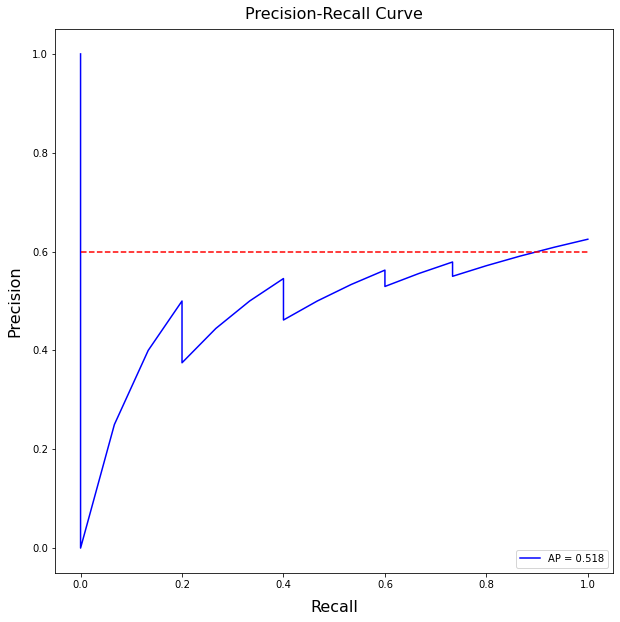

In [54]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label == 1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_image_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's evaluate the classification performance spectra-wise:

In [55]:
# Create single array of predictions and labels
predictions_and_labels = np.concatenate(
    [
        np.concatenate(
            [predictions[key],
             np.expand_dims(true_labels[key], axis=1)], axis=1
        ) for key in predictions.keys()
    ]
)

# Get accuracy
accuracy = metrics.accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get precision
precision = metrics.precision_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get recall
recall = metrics.recall_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Get  f1 score
f1 = metrics.f1_score(
    (predictions_and_labels[:, 0] > 0.5).astype(int), predictions_and_labels[:,
                                                                             1]
)

# Save performance
file_name = "section_replica_non_tissue_spectra_wise_performance.txt"
with open(f"{PLOTS_PATH}/{file_name}", "w") as file:
  file.write(f"Accuracy: {accuracy:.3f}\n")
  file.write(f"Balanced  Accuracy: {b_accuracy:.3f}\n")
  file.write(f"Precision: {precision:.3f}\n")
  file.write(f"Recall: {recall:.3f}\n")
  file.write(f"F1 score: {f1:.3f}\n")

# Print metrics
with open(f"{PLOTS_PATH}/{file_name}", "r") as file:
  print(file.read())

Accuracy: 0.540
Balanced  Accuracy: 0.433
Precision: 0.869
Recall: 0.569
F1 score: 0.688



Next, let's plot the roc curve spectra-wise:

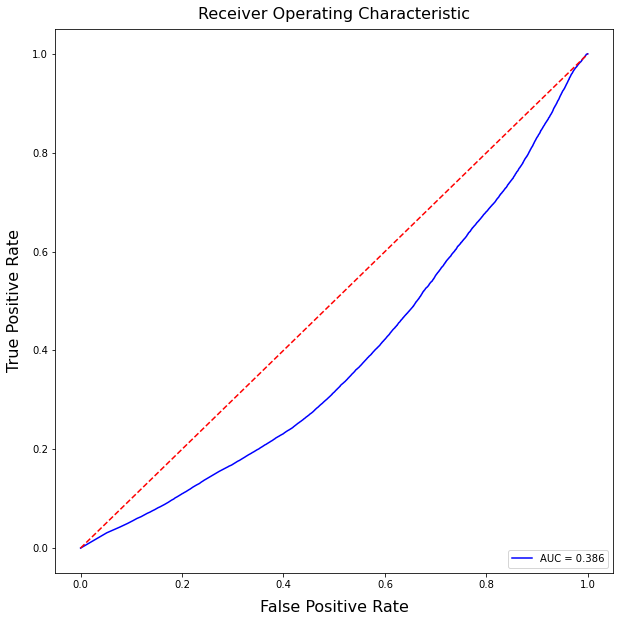

In [56]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate", labelpad=10, fontsize=16)
plt.xlabel("False Positive Rate", labelpad=10, fontsize=16)
plt.title("Receiver Operating Characteristic", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_spectra_wise_roc.png"),
    transparent=True
)
plt.show()

Next, let's plot the precision-recall curve spectra-wise:

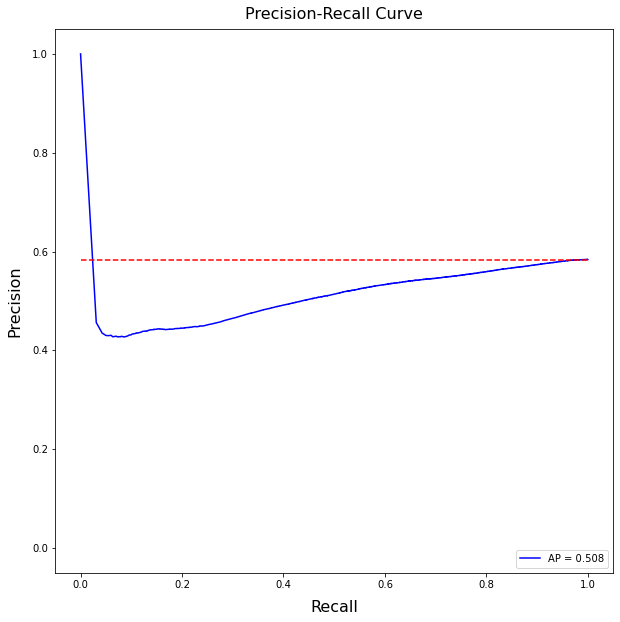

In [57]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
    predictions_and_labels[:, 1], predictions_and_labels[:, 0]
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(predictions_and_labels[:, 1] == 1
              ) / len(predictions_and_labels[:, 1])

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision", labelpad=10, fontsize=16)
plt.xlabel("Recall", labelpad=10, fontsize=16)
plt.title("Precision-Recall Curve", pad=10, fontsize=16)
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_spectra_wise_prc.png"),
    transparent=True
)
plt.show()

Next, let's plot the prediction heatmap for every sample:

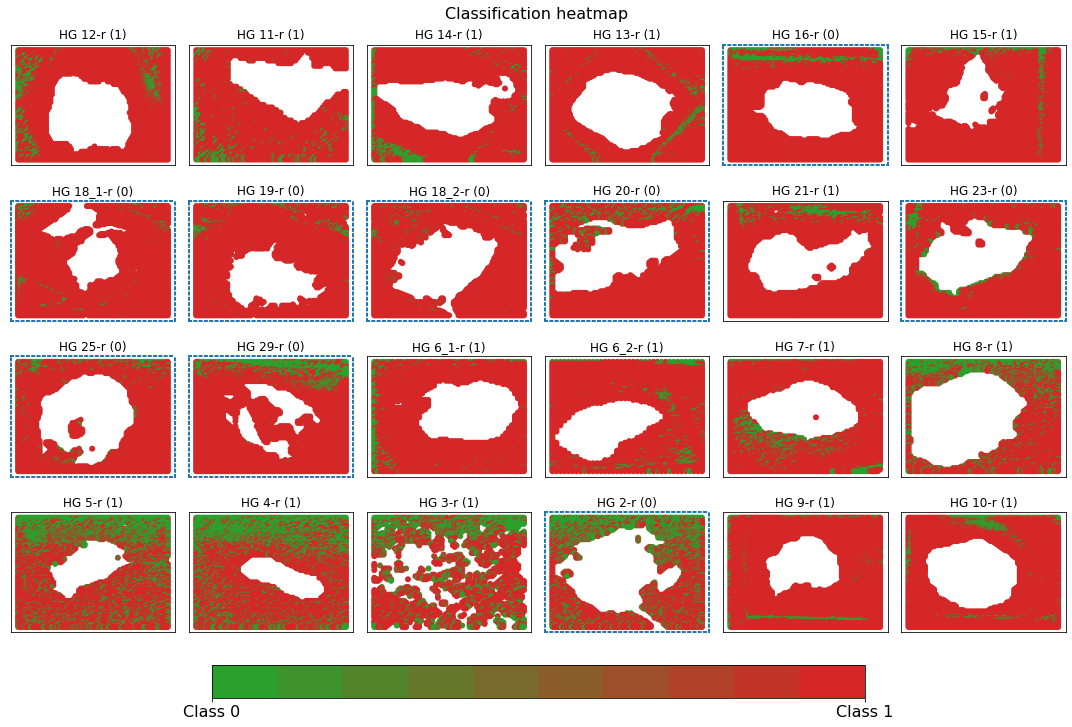

In [58]:
# Create custom binary color bar
colors = ["tab:green", "tab:red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(15, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(
      r_spectras_info[(r_spectras_info.file_name == key) &
                      ~r_spectras_info.is_tissue].x_coordinate - 1,
      r_spectras_info[(r_spectras_info.file_name == key) &
                      ~r_spectras_info.is_tissue].y_coordinate - 1,
      c=predictions[key], cmap=cm, edgecolor=['none'], vmin=0, vmax=1,
      linewidths=0
  )
  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xticks([])
  ax.set_yticks([])

  # make y-axis 0 at bottom same as imshow
  ax.invert_yaxis()

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification heatmap", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(
    im, ax=axes.ravel().tolist(), location="bottom", orientation="horizontal",
    fraction=0.05, pad=0.05
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"], fontsize=16)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_prediction_heatmap.png"),
    transparent=True, bbox_inches="tight"
)
plt.show()

Next, let's plot the prediction distribution for every sample:

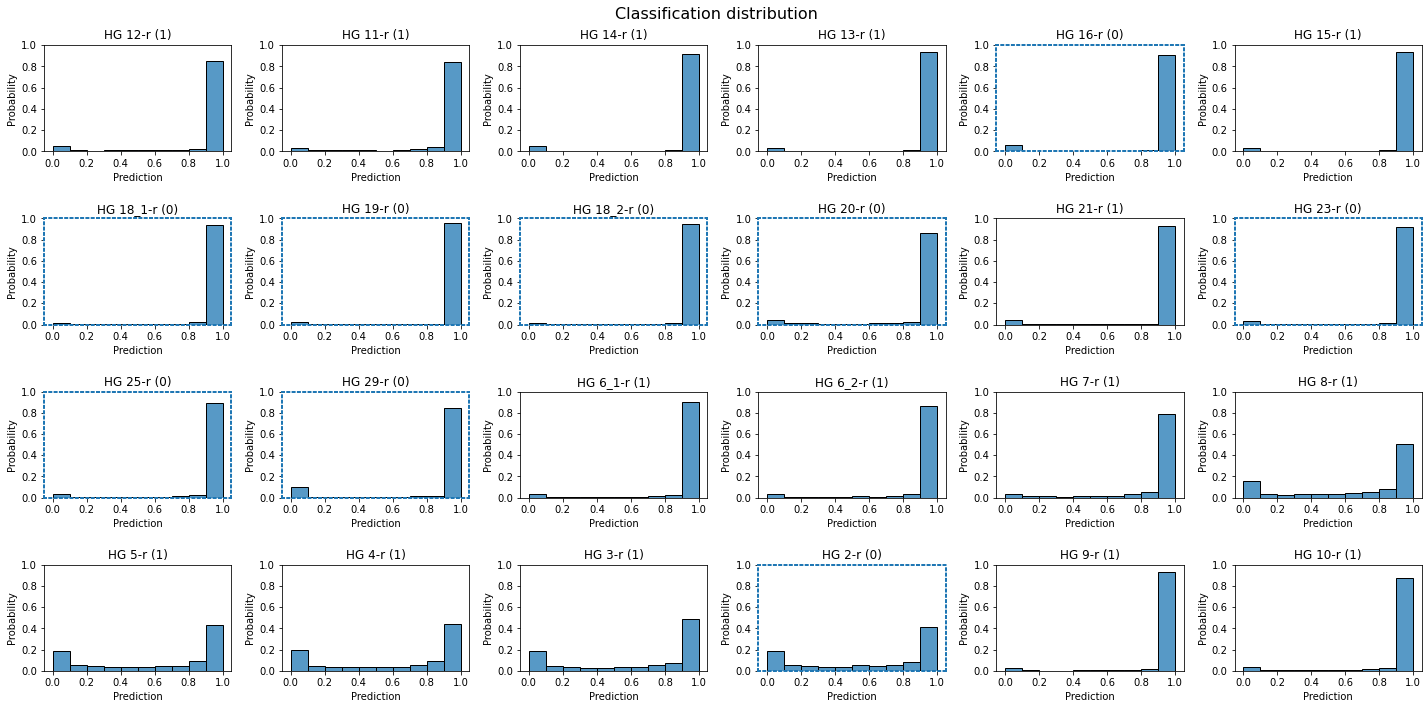

In [59]:
# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's prediction distribution
  ax = sns.histplot(
      x=predictions[key].flatten(), bins=10, binrange=[0, 1],
      stat="probability", ax=ax
  )

  # Set plot properties
  ax.set_title(f"{key} ({int(model_eval.loc[key].sample_label)})")
  ax.set_xlabel("Prediction")
  ax.set_ylim(0,1)

  # If misclassified change figure spline
  if model_eval.loc[key].sample_label != model_eval.loc[key].sample_prediction:
    #
    plt.setp(ax.spines.values(), color='tab:blue', linewidth=2, linestyle=":")

# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("Classification distribution", fontsize=16)

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Show plot
plt.savefig(
    (f"{PLOTS_PATH}/section_replica_non_tissue_distribution.png"), transparent=True
)
plt.show()

Next, lets save the predications and labels for each spectra:

In [60]:
pd.DataFrame(
    np.concatenate(
        [
            np.concatenate(
                [
                    np.full(predictions[key].shape, key),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            ~r_spectras_info.is_tissue].x_coordinate, 1
                    ),
                    np.expand_dims(
                        r_spectras_info[
                            (r_spectras_info.file_name == key) &
                            ~r_spectras_info.is_tissue].y_coordinate, 1
                    ), predictions[key],
                    np.expand_dims(true_labels[key], axis=1)
                ], axis=1
            ) for key in predictions.keys()
        ]
    ), columns=[
        "file_name", "x_coordinate", "y_coordinate", "prediction", "label"
    ]
).to_csv(
    f"{PLOTS_PATH}/section_section_non_tissue_spectra_wise_predictions.csv",
    index=False
)

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [61]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()